In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
  
#read the files
test=pd.read_csv('test_results.csv')

In [3]:
user = pd.read_csv("user_table.csv")

In [4]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


Join datasets

In [6]:
data=pd.merge(left=test, right=user, how='left',on='user_id')

In [7]:
data

,user_id,timestamp,source,device,operative_system,...,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,...,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,...,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,...,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,...,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,...,0,Fishers,USA,39.95,-86.02
...,...,...,...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,...,0,NaN,NaN,NaN,NaN
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,...,0,Bell Gardens,USA,33.97,-118.15
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,...,0,West Seneca,USA,42.84,-78.75
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,...,0,Walnut Creek,USA,37.90,-122.04


Data Exploration - Check if people in test always get the 59 and people in control 39.

In [8]:
print(data.isnull().sum())

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64


In [9]:
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918


It is not correct that users are assigned to two different test groups. Users within the same group should have the same price. Since the number of errors is very small, I just removed the wrong data points.

In [10]:
data=data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
1    59      113918


In [11]:
data.head()

,user_id,timestamp,source,device,operative_system,...,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,...,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,...,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,...,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,...,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,...,0,Fishers,USA,39.95,-86.02


In [12]:
data['sales']=data['converted']*data['price']

/var/folders/fm/0m2ss7v571591gzbw7gmjk6m0000gn/T/ipykernel_7480/3059835742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sales']=data['converted']*data['price']


In [14]:
data['sales'].describe()

count    316435.000000
mean          0.827083
std           6.179009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: sales, dtype: float64

Conversion rate Analysis

In [16]:
data[['converted','test']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


Conversion rate went down by roughly 25%. 

Avg sales per user Analysis

In [24]:
data[['sales','test']].groupby('test').mean()

,sales
test,
0,0.776083
1,0.917748


Avg sales per user went up after implementing price changes.

In [25]:
ttest_ind(data[data['test']==1]['sales'], data[data['test']==0]['sales'], equal_var=False)

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)

From the ttest result above,  and highly statistically significant.

User price sensitivity Analysis by segments

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'ads_facebook'),
  Text(1, 0, 'seo-google'),
  Text(2, 0, 'ads-bing'),
  Text(3, 0, 'direct_traffic'),
  Text(4, 0, 'ads-google'),
  Text(5, 0, 'seo_facebook'),
  Text(6, 0, 'friend_referral'),
  Text(7, 0, 'ads_other'),
  Text(8, 0, 'ads-yahoo'),
  Text(9, 0, 'seo-yahoo'),
  Text(10, 0, 'seo-bing'),
  Text(11, 0, 'seo-other')])

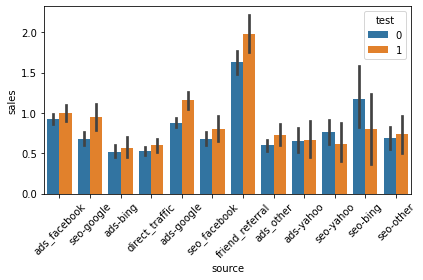

In [19]:
sns.barplot(x='source', y='sales', hue='test', data=data)
plt.xticks(rotation=45)

Most segments agree with the overall conclusion that revenue increases as we raise prices. But the three segments with higher average revenue at the new prices happen to be the most expensive segments. They are friend referrals, Google ads and FB ads.

(array([0, 1]), [Text(0, 0, 'mobile'), Text(1, 0, 'web')])

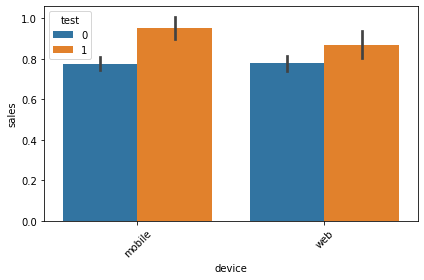

In [20]:
sns.barplot(x='device', y='sales', hue='test', data=data)
plt.xticks(rotation=45)

Mobile users are less price sensitive than web users.

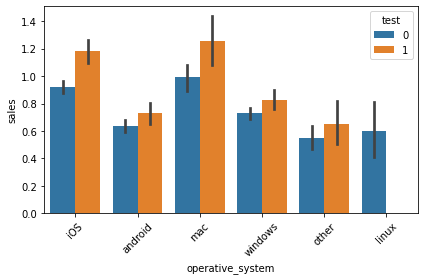

In [21]:
sns.barplot(x='operative_system', y='sales', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

Mac/iOS responded better to the price increase.

# Conclusions

Overall, if the goal of the test was to try to increase revenue, then based on the test results, we should continue to make changes.

- Mobile has larger sales per user than web.
- iOS is doing much better than Android. 
- Friend-referral is by far the best channel. 
- FB/Google ads have higher revenue per user than any other channel. 

There is one thing we should take into further consideration. It is possible that about 25% of customers will be lost, which may have negative results other than the test results since most of the sales resources come from referrals from friends.